# Distributed alternating direction method of multipliers (ADMM)

In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors
import opendssdirect as dss
from post_process.model_utils import ModelUtil
import pandas as pd
from pydantic import BaseModel
import json
import os
from oedisi.componentframework import wiring_diagram_utils
from oedisi.types.data_types import (
    Topology,
    Incidence
)
from post_process import plotter
from dataclasses import dataclass
from pprint import pprint

ROOT = os.getcwd()
OUTPUTS = f"{ROOT}/outputs"
SCENARIO_DIR, SCENARIOS, _ = next(os.walk(f'{ROOT}/scenario/'))

print(SCENARIO_DIR)
for idx, scenario in enumerate(SCENARIOS):
    print(idx, scenario)

ImportError: cannot import name 'Admittence' from 'oedisi.types.data_types' (/home/tylor/dev/oedisi_dopf/.venv/lib/python3.12/site-packages/oedisi/types/data_types.py)

## Select a scenario
Set the SCENARIOS index value from the available scenarios

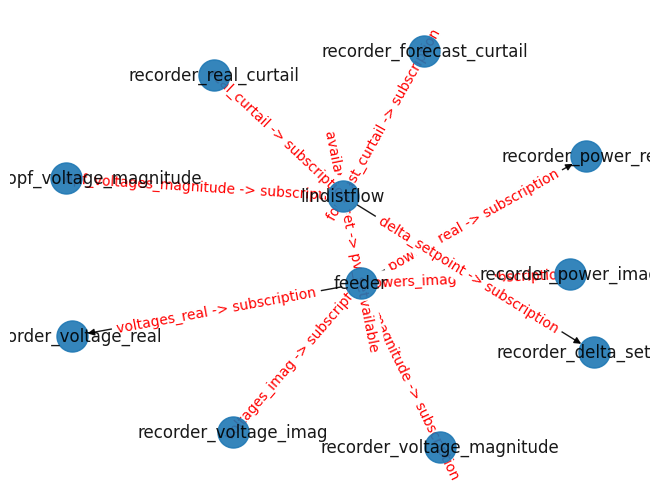

In [2]:
index = 15
SCENARIO = SCENARIOS[index]

path = f"{SCENARIO_DIR}{SCENARIO}"
with open(f"{path}/system.json") as f:
    wiring_diagram = wiring_diagram_utils.WiringDiagram.parse_obj(json.load(f))

wiring_diagram_utils.plot_graph_matplotlib(wiring_diagram)

## Build the selected scenario
The build will create a new build_<scenario> folder and copy over the federate files as specified. Assume successful build if no errors are presented.

In [15]:
os.system(f"oedisi build --system {path}/system.json --component-dict {path}/components.json --target-directory build_{SCENARIO}")

Loading the components defined in /home/tylor/dev/oedisi_dopf/scenario/large/components.json
Loading system json /home/tylor/dev/oedisi_dopf/scenario/large/system.json
Building system in build_large


0

## Model Topology
split model into areas using discconnection switches

In [28]:
topology_file = f"{OUTPUTS}/{SCENARIO}/topology.json"
with open(topology_file) as f:
    topology = Topology.parse_obj(json.load(f))

def generate_graph(topology: Topology) -> nx.Graph:
    to_eq = topology.admittance.to_equipment
    fr_eq = topology.admittance.from_equipment
    graph = nx.Graph()
    for src, dst in zip(fr_eq, to_eq):
        if "OPEN" in src or "OPEN" in dst:
            continue
        if src == dst:
            continue
        graph.add_edge(src, dst)
    disconnected = list(nx.connected_components(graph))
    for d in disconnected:
        if any([b in d for b in topology.slack_bus]):
            return d
print(generate_graph(topology))

Graph with 274 nodes and 848 edges
1
['150.1', '150.2', '150.3']
{'65.3', '49.2', '68.1', '93.2', '77.1', '25R.1', '95.1', '151.2', '42.1', '21.2', '78.3', '22.2', '35.3', '57.2', '63.1', '30.1', '98.2', '70.1', '101.3', '93.3', '49.1', '99.2', '25R.3', '100.2', '67.1', '89.2', '30.3', '13.2', '47.3', '78.1', '9.1', '81.2', '74.3', '109.1', '18.2', '36.2', '63.2', '65.2', '450.3', '24.3', '67.2', '90.2', '76.3', '110.1', '50.1', '53.2', '64.3', '80.2', '150.3', '76.2', '53.1', '29.1', '53.3', '160.2', '52.2', '78.2', '9R.1', '36.1', '91.3', '97.3', '44.3', '112.1', '1.2', '160R.2', '26.1', '66.3', '86.1', '51.2', '34.3', '86.3', '17.3', '8.1', '15.3', '47.2', '160.1', '48.3', '76.1', '61S.2', '79.1', '30.2', '8.3', '50.3', '14.1', '23.2', '4.3', '35.1', '160R.1', '38.2', '73.3', '300.2', '108.1', '105.1', '250.3', '1.3', '61.3', '57.3', '48.2', '450.2', '114.1', '35.2', '25.1', '72.1', '49.3', '60.1', '64.2', '97.1', '150R.1', '66.1', '45.1', '21.3', '23.1', '44.2', '10.1', '39.2', '65

In [22]:

    
from lindistflow_federate.adapter import (
    SwitchInfo,
    extract_switches,
    extract_info,
)


branch_ = extract_info(topology)
for k,v in branch.items():
    if v["type"] == "SWITCH":
        print(k, v)
        
def init_branch() -> dict:
    branch = {}
    branch["fr_bus"] = ""
    branch["to_bus"] = ""
    branch["phases"] = []
    branch["type"] = ""
    return branch

@dataclass
class SwitchInfo:
    name: str
    from_bus: str
    to_bus: str
    
def extract_switches(incidences: dict) -> list[SwitchInfo]:
    switches = []
    from_eq = incidences["from_equipment"]
    to_eq = incidences["to_equipment"]
    ids = incidences["ids"]
    for fr_eq, to_eq, eq_id in zip(from_eq, to_eq, ids):
        if ("sw" in eq_id or "fuse" in eq_id) and "padswitch" not in eq_id:
            if "." in fr_eq:
                [fr_eq, _] = fr_eq.split('.',1)
            if "." in to_eq:
                [to_eq, _] = to_eq.split('.',1)
            switches.append(
                SwitchInfo(
                    name=eq_id, 
                    from_bus=fr_eq, 
                    to_bus=to_eq))   

    return switches
    
def extract_info(topology: Topology,switches: list[SwitchInfo]) -> dict:
    branch_info = {}
    from_equip = topology.admittance.from_equipment
    to_equip = topology.admittance.to_equipment
    fr_buses = [switch.from_bus for switch in switches]
    to_buses = [switch.to_bus for switch in switches]

    for fr_eq, to_eq in zip(from_equip, to_equip):
        type = "LINE"
        [from_name, from_phase] = fr_eq.split('.')
        [to_name, to_phase] = to_eq.split('.')

        forward_link = from_name in fr_buses and to_name in to_buses
        reverse_link = to_name in fr_buses and from_name in to_buses
        if forward_link or reverse_link:
            type = "SWITCH"

        if from_name == to_name:
            continue

        key = f"{from_name}_{to_name}"
        key_back = f"{to_name}_{from_name}"

        if key not in branch_info and key_back not in branch_info:
            branch_info[key] = init_branch()
        elif key_back in branch_info:
            continue

        if from_phase not in branch_info[key]['phases']:
            branch_info[key]['phases'].append(from_phase)

        branch_info[key]['type'] = type
        branch_info[key]['fr_bus'] = from_name.upper()
        branch_info[key]['to_bus'] = to_name.upper()

    return branch_info



1 P1UDT908_P1UDT908-P1UDT909X
2 P1UDT1433_P1UDT1433-P1UDT882X
3 P1UDT881_P1UDT1432-P1UDT881X
4 P1UDT938_P1UDT896-P1UDT938X
5 P1UDT894-P1UDT942X_P1UDT942
6 P1UDT894-P1UDT895X_P1UDT894
7 P1UDT894-P1UDT942X_P1UDT894
8 P1UDT881_P1UDT1425-P1UDT881X
9 P1UDT1425_P1UDT1425-P1UDT881X
10 P1UDT895_P1UDT1431-P1UDT895X
11 P1UDT895_P1UDT894-P1UDT895X


## Areas

1 Graph with 4 nodes and 3 edges (np.float64(1.0), np.float64(0.4313725490196079), np.float64(0.0), np.float64(1.0))
2 Graph with 21 nodes and 20 edges (np.float64(0.9750927397986221), np.float64(1.0), np.float64(0.0), np.float64(1.0))
3 Graph with 15 nodes and 14 edges (np.float64(0.36036036036036034), np.float64(1.0), np.float64(0.0), np.float64(1.0))
4 Graph with 5 nodes and 4 edges (np.float64(0.0), np.float64(1.0), np.float64(0.23192072527935917), np.float64(1.0))
5 Graph with 9 nodes and 8 edges (np.float64(0.0), np.float64(1.0), np.float64(0.8433480919249424), np.float64(1.0))
6 Graph with 4 nodes and 3 edges (np.float64(0.0), np.float64(0.5615942028985503), np.float64(1.0), np.float64(1.0))
7 Graph with 16 nodes and 15 edges (np.float64(0.056479113384484365), np.float64(0.0), np.float64(1.0), np.float64(1.0))
8 Graph with 4 nodes and 3 edges (np.float64(0.6532395566922424), np.float64(0.0), np.float64(1.0), np.float64(1.0))
9 Graph with 3 nodes and 2 edges (np.float64(1.0), np.

TypeError: extract_info() takes 1 positional argument but 2 were given

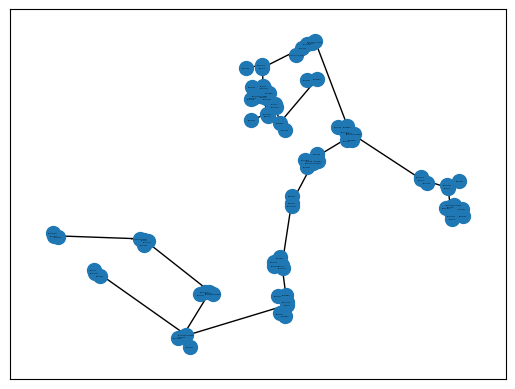

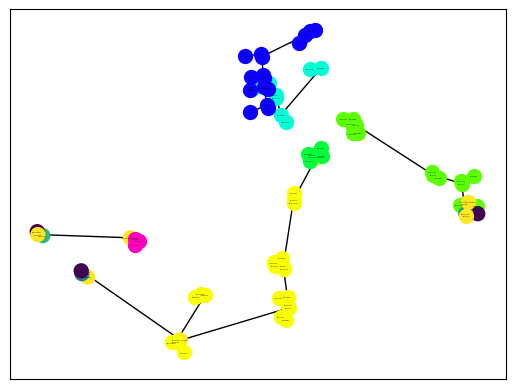

In [23]:
coords_file = f"{OUTPUTS}/{SCENARIO}/BusCoords.dat"
pos = {}
with open(coords_file) as f:
   for line in f:
       values = line.split()
       if len(values) == 3:
           x = float(values[1])
           y = float(values[2])
           pos[values[0].upper()] = (x,y)
    
full_graph = nx.Graph()
for b in branch:
    fr_bus = branch[b]["fr_bus"]
    to_bus = branch[b]["to_bus"]
    if fr_bus in pos.keys() and to_bus in pos.keys():
        full_graph.add_edge(fr_bus, to_bus)

options = {
    "font_size": 1,
    "node_size": 100,
    "linewidths": 1,
    "width": 1,
}
nx.draw_networkx(full_graph, pos, **options)
        
dissconnected_graph = nx.Graph()
for b in branch:
    if branch[b]['type'] != 'SWITCH':
        dissconnected_graph.add_edge(branch[b]['fr_bus'],
                       branch[b]['to_bus'])

sp_graph = list(nx.connected_components(dissconnected_graph))

areas = {}
area_idx = 0
for k in sp_graph:
    if len(k) > 2:
        area_idx += 1
        area = nx.Graph()
        for b in branch:
            fr_bus = branch[b]["fr_bus"]
            to_bus = branch[b]["to_bus"]
            if fr_bus in k and to_bus in k:
                area.add_edge(fr_bus, to_bus)
        areas[area_idx] = area
    
cmap = plt.colormaps['gist_rainbow']
area_count = len(areas)
fig, ax = plt.subplots()
for k,v in areas.items():
    c = cmap(k/area_count)
    print(k,v,c)
    nx.draw_networkx(v, pos, **options, node_color=c)

area_nodes = [area.number_of_nodes() for area in areas.values()]
area_nodes.sort(reverse=True)
print("Areas: ", area_nodes[1:10])


for k,v in areas.items():
    if v.number_of_nodes() < min(area_nodes[1:10]):
        fr_buses = [switch.from_bus for switch in switches]
        to_buses = [switch.to_bus for switch in switches]
        edges = v.edges()
        for e1,e2 in edges:
            switches = [switch for switch in switches if e1 not in switch.name.upper()]
            switches = [switch for switch in switches if e2 not in switch.name.upper()]

pprint(switches)
branch = extract_info(topology, switches)
dissconnected_graph = nx.Graph()
for b in branch:
    if branch[b]['type'] != 'SWITCH':
        dissconnected_graph.add_edge(branch[b]['fr_bus'],
                       branch[b]['to_bus'])

sp_graph = list(nx.connected_components(dissconnected_graph))

areas = {}
area_idx = 0
for k in sp_graph:
    if len(k) > 2:
        area_idx += 1
        area = nx.Graph()
        for b in branch:
            fr_bus = branch[b]["fr_bus"]
            to_bus = branch[b]["to_bus"]
            if fr_bus in k and to_bus in k:
                area.add_edge(fr_bus, to_bus)
        areas[area_idx] = area
    
cmap = plt.colormaps['gist_rainbow']
area_count = len(areas)
fig, ax = plt.subplots()
for k,v in areas.items():
    c = cmap(k/area_count)
    print(k,v,c)
    nx.draw_networkx(v, pos, **options, node_color=c)

## Generate system.json

In [27]:
class Link(BaseModel):
    source: str
    source_port: str
    target: str
    target_port: str
    

class Component(BaseModel):
    name: str
    federate_type: str
    parameters: dict[str,str]
    

class System(BaseModel):
    name: str
    components: list[Component]
    links: list[Link]
    

system = System(name=f"{SCENARIO}_areas", components=[], links=[])
for switch in switches:
    name = switch.name
    if "(" in name or ")" in name:
        name = switch.name[:switch.name.find("(")] + "_" + switch.name[switch.name.find(")")+1:]
    c = Component(
        name=name, 
        federate_type="OptimalPowerFlow", 
        parameters={"deltat":"0.1", "pf_flag":"true", "control_type":"1"}
    )
    system.components.append(c)

    r_name = f"{name}_recorder_setpoints"
    rec_setpoints = Component(
        name=r_name, 
        federate_type="Recorder", 
        parameters={
            "feather_filename":f"../../outputs/{SCENARIO}/{r_name}.feather",
            "csv_filename":f"../../outputs/{SCENARIO}/{r_name}.csv"
        }
    )
    system.components.append(rec_setpoints)

    r_name = f"{name}_recorder_real_curtail"
    rec_real = Component(
        name=r_name, 
        federate_type="Recorder", 
        parameters={
            "feather_filename":f"../../outputs/{SCENARIO}/{r_name}.feather",
            "csv_filename":f"../../outputs/{SCENARIO}/{r_name}.csv"
        }
    )
    system.components.append(rec_real)

    r_name = f"{name}_recorder_forecast_curtail"
    rec_forecast = Component(
        name=r_name, 
        federate_type="Recorder", 
        parameters={
            "feather_filename":f"../../outputs/{SCENARIO}/{r_name}.feather",
            "csv_filename":f"../../outputs/{SCENARIO}/{r_name}.csv"
        }
    )
    system.components.append(rec_forecast)

    topology = Link(
        source="feeder",
        source_port="topology",
        target=c.name,
        target_port="topology"
    )
    system.links.append(topology)
    
    injections = Link(
        source="feeder",
        source_port="injections",
        target=c.name,
        target_port="injections"
    )
    system.links.append(injections)
    
    voltages_magnitude = Link(
        source="feeder",
        source_port="voltages_magnitude",
        target=c.name,
        target_port="voltages_magnitude"
    )
    system.links.append(voltages_magnitude)
        
    pv_forecast = Link(
        source="feeder",
        source_port="pv_forecast",
        target=c.name,
        target_port="pv_forecast"
    )
    system.links.append(pv_forecast)
        
    pv_available = Link(
        source="feeder",
        source_port="pv_available",
        target=c.name,
        target_port="pv_available"
    )
    system.links.append(pv_forecast)
        
    pv_set = Link(
        source=c.name,
        source_port="pv_set",
        target="feeder",
        target_port="pv_set"
    )
    system.links.append(pv_set)
        
    pv_set = Link(
        source=c.name,
        source_port="pv_set",
        target="feeder",
        target_port="pv_set"
    )
    system.links.append(pv_set)
              
    pv_set = Link(
        source=c.name,
        source_port="delta_setpoints",
        target=rec_setpoints.name,
        target_port="subscription"
    )
    system.links.append(pv_set)
              
    pv_set = Link(
        source=c.name,
        source_port="real_curtail",
        target=rec_real.name,
        target_port="subscription"
    )
    system.links.append(pv_set)
                   
    pv_set = Link(
        source=c.name,
        source_port="forecast_curtail",
        target=rec_forecast.name,
        target_port="subscription"
    )
    system.links.append(pv_set)

pprint(system)
      
    


System(name='large_areas', components=[Component(name='fuse_p9u_178111', federate_type='OptimalPowerFlow', parameters={'deltat': '0.1', 'pf_flag': 'true', 'control_type': '1'}), Component(name='fuse_p9u_178111_recorder_setpoints', federate_type='Recorder', parameters={'feather_filename': '../../outputs/large/fuse_p9u_178111_recorder_setpoints.feather', 'csv_filename': '../../outputs/large/fuse_p9u_178111_recorder_setpoints.csv'}), Component(name='fuse_p9u_178111_recorder_real_curtail', federate_type='Recorder', parameters={'feather_filename': '../../outputs/large/fuse_p9u_178111_recorder_real_curtail.feather', 'csv_filename': '../../outputs/large/fuse_p9u_178111_recorder_real_curtail.csv'}), Component(name='fuse_p9u_178111_recorder_forecast_curtail', federate_type='Recorder', parameters={'feather_filename': '../../outputs/large/fuse_p9u_178111_recorder_forecast_curtail.feather', 'csv_filename': '../../outputs/large/fuse_p9u_178111_recorder_forecast_curtail.csv'}), Component(name='fuse_

## Run selected scenario
The simulation will take 5-30 minutes to run depending on the scenario. The results will print Done once complete.

In [ ]:
os.system("pkill -9 helics_broker")
os.system(f"oedisi run --runner build_{SCENARIO}/system_runner.json")

[warn] helics-cli's web interface is not installed. You may want to run `pip install "helics[cli]"`.
[warn] helics-cli's observer functionality is not installed. You may want to run `pip install "helics[cli]"`.
[info] Running federation: large
[info] Running federate recorder_power_real as a background process
[info] Running federate recorder_power_imag as a background process
[info] Running federate recorder_voltage_real as a background process
[info] Running federate recorder_voltage_imag as a background process
[info] Running federate recorder_voltage_magnitude as a background process
[info] Running federate recorder_opf_voltage_magnitude as a background process
[info] Running federate recorder_delta_setpoint as a background process
[info] Running federate recorder_forecast_curtail as a background process
[info] Running federate recorder_real_curtail as a background process
[info] Running federate feeder as a background process
[info] Running federate lindistflow as a background pro